In [1]:
from src.data.data_utils import query_mlb_db

In [120]:
kukuchi = 579328
jones = 683003

pitcher = jones

In [136]:
query_str = f'''
    SELECT pitch_type, batter, pitch_number, strikes, balls, outs_when_up,
        CASE
            when stand='R' then 1
            else 0
        END AS stand,
        CASE
            when on_1b is not null then 1
            else 0
        END AS on_1b,
        CASE
            when on_2b is not null then 1
            else 0
        END AS on_2b,
        CASE
            when on_3b is not null then 1
            else 0
        END AS on_3b,
        CASE
            when fld_score - bat_score > 0 then 1
            when fld_score - bat_score = 0 then 0
            else -1
        END AS is_winning,
        LAG(pitch_type) OVER (PARTITION BY game_pk, pitcher, at_bat_number ORDER BY pitch_number) AS prev_pitch,
        ROW_NUMBER() OVER (PARTITION BY game_pk, pitcher ORDER BY at_bat_number, pitch_number) AS cumulative_pitch_number
    FROM Statcast
    WHERE pitcher = {pitcher}
        AND pitch_type IS NOT NULL
        and pitch_type <> 'PO'
        AND game_type <> 'E' || 'S'
    ORDER BY game_pk, at_bat_number, pitch_number
'''
df = query_mlb_db(query_str)

In [141]:
# add batters woba into pitch arsenal

def get_woba_strike_df(df):
    pitch_arsenal = df['pitch_type'].unique()
    print(pitch_arsenal)

get_woba_strike_df(df)

['FF' 'CH' 'SL' 'CU']


In [137]:
df

,pitch_type,batter,pitch_number,strikes,balls,outs_when_up,stand,on_1b,on_2b,on_3b,is_winning,prev_pitch,cumulative_pitch_number
0,FF,808982,1,0,0,0,0,0,0,0,0,None,1
1,FF,664774,1,0,0,1,0,0,0,0,0,None,2
2,CH,664774,2,0,1,1,0,0,0,0,0,FF,3
3,SL,664774,3,0,2,1,0,0,0,0,0,CH,4
4,FF,664774,4,1,2,1,0,0,0,0,0,SL,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,SL,622569,3,1,1,2,1,0,1,0,-1,FF,79
566,FF,622569,4,2,1,2,1,0,1,0,-1,SL,80
567,SL,622569,5,2,1,2,1,0,1,0,-1,FF,81
568,SL,622569,6,2,2,2,1,0,1,0,-1,SL,82


In [123]:
df['pitch_type'].value_counts() / len(df)

pitch_type
FF    0.468421
SL    0.391228
CU    0.073684
CH    0.066667
Name: count, dtype: float64

In [124]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from copy import deepcopy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_col = 'pitch_type'
encoders = {} # to store encoders

le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(df['pitch_type']), columns=[target_col])

encoders[target_col] = deepcopy(le)

X = df.drop(target_col, axis=1)

def encode_cat_cols(X, encoders_dict):
    cat_encoded_dfs = {}
    object_cols = [col for col in X.columns if X[col].dtype == 'object']
    for col in object_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders_dict[col] = deepcopy(le)

    return X, encoders_dict

X, encoders = encode_cat_cols(X, encoders)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [125]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 455
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   pitch_number             456 non-null    int64
 1   strikes                  456 non-null    int64
 2   balls                    456 non-null    int64
 3   outs_when_up             456 non-null    int64
 4   stand                    456 non-null    int64
 5   on_1b                    456 non-null    int64
 6   on_2b                    456 non-null    int64
 7   on_3b                    456 non-null    int64
 8   is_winning               456 non-null    int64
 9   prev_pitch               456 non-null    int64
 10  cumulative_pitch_number  456 non-null    int64
dtypes: int64(11)
memory usage: 42.8 KB


In [126]:
xgb_params = {"max_depth": (2, 5, 20),
              "learning_rate": (0.01, 0.1, 0.4),
              "n_estimators": (100,300,500)
             }

# perform the paramater grid search using 5-fold cross validation
xgb_opt = GridSearchCV(xgb.XGBClassifier(objective='multi:softprob', 
                                         n_estimators=100,
                                         eval_metric='mlogloss'
                                        ), 
                       param_grid=xgb_params, 
                       cv=5, 
                       scoring='accuracy', 
                       verbose=1, 
                       n_jobs=-1)

# perform fit and make predictions
xgb_opt.fit(X_train, y_train)
y_pred = xgb_opt.predict(X_test)
y_prob = xgb_opt.predict_proba(X_test)
print(xgb_opt.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}


In [127]:
params = {'objective' : 'multi:softprob',
          'eval_metric': 'mlogloss',      
          'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators': 500 
         }

clf = xgb.XGBClassifier(**params, tree_method="exact", booster="dart")
    
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [128]:
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

In [129]:
print("Accuracy:", accuracy_score(y_test, y_pred))
clf.score(X_test, y_test)

Accuracy: 0.4649122807017544


0.4649122807017544

In [130]:
#likelihoods = y_pred_proba[np.arange(len(y_pred_proba)), y_test]
#likelihoods.shape
#print(y_pred_proba)
#y_pred_proba[:, y_test['pitch_type']]

def compute_xgboost_loglik(y_pred_proba, y_test):
    loglik = 0
    for idx, pitch_type in enumerate(y_test['pitch_type']):
        loglik += np.log(y_pred_proba[idx, pitch_type])
    return loglik

compute_xgboost_loglik(y_pred_proba, y_test)

-142.80763800814748

In [131]:
def compute_cat_loglik(df, target_col, y_test):
    pitch_cat_prob = (df['pitch_type'].value_counts() / len(df)).reset_index()
    pitch_cat_prob[f'{target_col}_encoded'] = encoders[target_col].transform(pitch_cat_prob[target_col])
    pitch_cat_prob.set_index(f'{target_col}_encoded')
    
    loglik = 0
    for idx, pitch_type in enumerate(y_test[target_col]):
        loglik += np.log(pitch_cat_prob.loc[pitch_type]['count'])
    return loglik

compute_cat_loglik(df, target_col, y_test)

-272.57022330686175

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

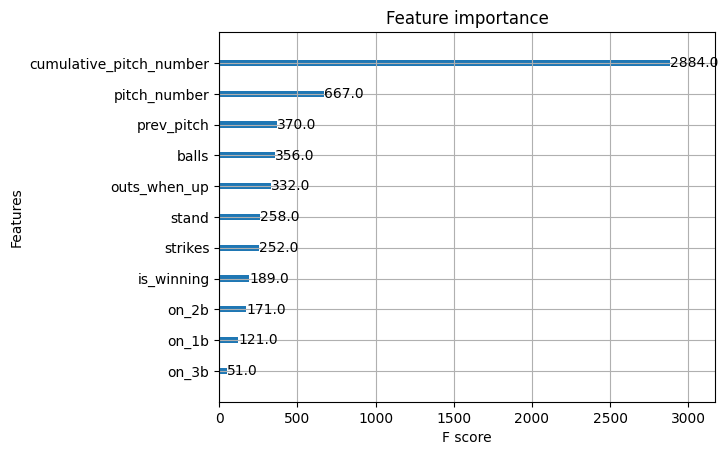

In [132]:
import matplotlib.pyplot as plt

xgb.plot_importance(clf)

In [133]:
#y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4649122807017544
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        10
           2       0.52      0.60      0.56        48
           3       0.46      0.49      0.48        49

    accuracy                           0.46       114
   macro avg       0.24      0.27      0.26       114
weighted avg       0.42      0.46      0.44       114



/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [134]:
pd.DataFrame(encoders['pitch_type'].inverse_transform(y_pred), columns=['pitch_type'])['pitch_type'].value_counts()

pitch_type
FF    56
SL    52
CH     6
Name: count, dtype: int64

In [135]:
pd.DataFrame(encoders['pitch_type'].inverse_transform(y_test), columns=['pitch_type'])['pitch_type'].value_counts()

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pitch_type
SL    49
FF    48
CU    10
CH     7
Name: count, dtype: int64

In [57]:
# Make predictions on test data
#xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.22831632653061223
              precision    recall  f1-score   support

           0       0.29      0.06      0.09       301
           1       0.11      0.00      0.00       457
           2       0.00      0.00      0.00         0
           3       0.47      0.44      0.46      1011
           4       0.36      0.18      0.24       583

   micro avg       0.43      0.24      0.31      2352
   macro avg       0.25      0.14      0.16      2352
weighted avg       0.35      0.24      0.27      2352
 samples avg       0.24      0.24      0.24      2352



/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
query_str = f'''
    select pitch_type, woba_value, type from Statcast where batter = 665742
'''

df = query_mlb_db(query_str)

In [85]:
df

,pitch_type,woba_value,type
0,CH,0.0,X
1,CU,NaN,B
2,FF,0.9,X
3,CH,NaN,B
4,CU,0.7,B
...,...,...,...
15340,FF,NaN,S
15341,FS,NaN,B
15342,FS,NaN,B
15343,FF,NaN,S


In [92]:
filtered_df = df.dropna(subset=['woba_value'])

pitch_type_stats = filtered_df.groupby('pitch_type').agg({'woba_value': 'mean', 'pitch_type': 'count'})
pitch_type_stats.columns = ['average_woba', 'pitch_count']

print(pitch_type_stats)

            average_woba  pitch_count
pitch_type                           
CH              0.349042          522
CU              0.335650          223
FA              1.000000            2
FC              0.397584          269
FF              0.478646         1152
FO              0.000000            1
FS              0.408911          101
KC              0.353448           87
SI              0.432488          651
SL              0.343423          555
ST              0.404478           67
SV              0.100000           14


In [90]:
average_woba_by_type = filtered_df.groupby('type')['woba_value'].mean()
average_woba_by_type

type
B    0.694607
S    0.001084
X    0.439458
Name: woba_value, dtype: float64

In [138]:
#strike % + flyout %
test_df = query_mlb_db('''
    select pitch_type, type, count(*) as num
    from Statcast
    where pitcher=579328
        and pitch_type is not null
        and pitch_type <> 'PO'
    group by pitch_type, type
    order by pitch_type, num desc;
''')

In [142]:
import pandas as pd
from scipy.stats import zscore

df = query_mlb_db('''select 
                        batter, pitch_type, type, woba_value 
                    from Statcast 
                    where pitch_type is not null
                        and pitch_type <>'PO' ''')

In [143]:
df.head()

,batter,pitch_type,type,woba_value
0,488726,SL,S,0.0
1,488726,FF,S,NaN
2,488726,FF,B,NaN
3,488726,FF,S,NaN
4,488726,SL,B,NaN


In [146]:

# Filter data for pitches seen at least 100 times
min_pitch_count = 100
filtered_data = df.groupby(['batter', 'pitch_type']).filter(lambda x: len(x) >= min_pitch_count)

# Calculate strike percentage for each batter and pitch type
#strike_percentage = filtered_data.groupby(['batter', 'pitch_type']).apply(lambda x: (x['type'] == 'S').mean() * 100)
strike_percentage = filtered_data.groupby(['batter', 'pitch_type'])['type'].apply(lambda x: (x == 'S').mean() * 100)

# Standardize strike percentage using z-score normalization
strike_percentage_standardized = strike_percentage.groupby('pitch_type').transform(zscore).reset_index()

In [154]:
#pitch_arsenal
strike_df = strike_percentage_standardized.pivot(index='batter', columns='pitch_type', values='type').fillna(0)[pitch_arsenal]

In [156]:
min_hit_count = 10
filtered_data = df[df['type'] == 'X'].groupby(['batter', 'pitch_type']).filter(lambda x: (x['type'] == 'X').sum() >= min_hit_count)
average_woba = filtered_data.groupby(['batter', 'pitch_type'])['woba_value'].mean()
average_woba_standardized = average_woba.groupby('pitch_type').transform(zscore).reset_index()

In [162]:
woba_df = average_woba_standardized.pivot(index='batter', columns='pitch_type', values='woba_value').fillna(0)[pitch_arsenal]

In [158]:
strike_percentage_standardized.loc[665742]
average_woba_standardized.loc[665742]

pitch_type
CH    0.185386
CU   -0.142520
FC    0.359533
FF    1.406326
FS    0.633659
KC   -0.176368
SI    0.915065
SL    0.358008
ST    0.785330
Name: woba_value, dtype: float64

In [164]:
strike_percentage_standardized.loc[676914]
average_woba_standardized.loc[676914]

pitch_type
FC    0.160611
FF    3.022650
SI    1.635868
SL    1.421666
Name: woba_value, dtype: float64

In [166]:
average_woba_standardized.loc[665489]
strike_percentage_standardized.loc[665489]

pitch_type
CH    0.042297
CU   -0.948692
FC   -1.602577
FF   -1.335562
FS   -0.703177
KC   -2.024977
SI   -0.968437
SL   -1.559329
ST   -0.589394
Name: type, dtype: float64

In [153]:
df[df['type']=='X']

,batter,pitch_type,type,woba_value
10,543807,FF,X,0.00
12,665742,CH,X,0.00
14,543685,FF,X,0.00
20,594809,FF,X,0.90
30,645302,SL,X,0.90
...,...,...,...,...
4892963,630105,SL,X,1.25
4892965,592518,FF,X,0.00
4892970,593428,FS,X,0.00
4892972,677942,KC,X,0.00


In [79]:
test_df['num'] / test_df['num'].sum()
test_df

,pitch_type,num
0,FF,5173
1,SL,2890
2,FC,1364
3,CU,1186
4,CH,1143
